In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from time import time
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)
seed_val = 42
np.random.seed(seed_val)


# Question 1

**Convolution function**: It accepts an 
* image input
* a filter kernel,
*  stride,
*  padding
*  the nonlinear activation function (e.g., ReLU, sigmoid, etc.).

The function must perform convolution operation on the input image (after padding if specified) with the kernel (with the specified stride size) and generate an output activation after applying the specified non-linearity. You may include the standard options for the non-linear activation functions - sigmoid, tanh, ReLU, Leaky ReLU.

Display the input image (e.g. a small image of the IITH logo), the filter kernel, and the output activation map. Ensure that your function can accept multi-channel input and a corresponding kernel volume.

In [2]:
def sigmoid(x):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def softmax(x):
    """Softmax activation function"""
    #transformed representation for avoiding overshooting of softmax 
    exp_values = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=-1, keepdims=True)

def tanh(x):
    """Hyperbolic tangent activation function"""
    return np.tanh(x)

def leaky_relu(x, alpha=0.01):
    """Leaky ReLU activation function"""
    return np.where(x > 0, x, alpha * x)


In [3]:
## uses 3d kernel
def convolution(image, kernel, stride, padding=0,activation='relu'):

    # Extract dimensions
    image_height, image_width, image_channels = image.shape
    kernel_height, kernel_width,kernel_channels = kernel.shape

    # Padding
    if padding > 0:
        image = np.pad(image, [(padding, padding), (padding, padding), (0, 0)], mode='constant')
    
    # Ensure the number of input channels in the filter kernel matches the input image
    assert image_channels == kernel_channels, "Number of input channels must match the filter kernel"
    
    # Compute output dimensions
    output_height = (image_height - kernel_height + 2 * padding) // stride + 1
    output_width = (image_width - kernel_width + 2 * padding) // stride + 1
    
    # Initialize output activation map
    output_activation = np.zeros((output_height, output_width))
   
    for c in range(image_channels):          
        tmp_y = out_y = 0 
        while tmp_y + kernel_height <= image.shape[1]:
            tmp_x = out_x = 0
            while tmp_x + kernel_width <= image.shape[0]:
                patch = image[tmp_y:tmp_y + kernel_height, tmp_x:tmp_x + kernel_width,c]
                output_activation[out_y, out_x] += np.sum(kernel[:,:,c] * patch)
                tmp_x += stride
                out_x += 1
            tmp_y += stride
            out_y += 1
        
        # Apply activation function
        if activation == 'relu':
            output_activation = relu(output_activation)
        elif activation == 'sigmoid':
            output_activation = sigmoid(output_activation)
        elif activation == 'tanh':
            output_activation = tanh(output_activation)
        elif activation == 'leaky_relu':
            output_activation = leaky_relu(output_activation)
        
    return output_activation


(369, 369, 3)


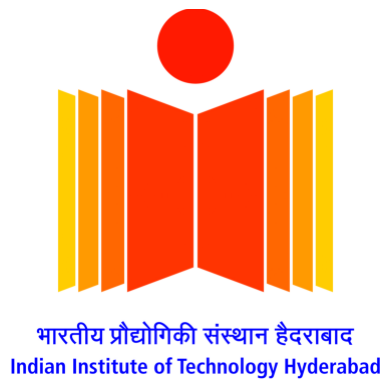

In [4]:
# Load the image using Matplotlib
def plot_image(image_name):
    image = mpimg.imread(image_name)  
    print(image.shape)
    
    plt.imshow(image)
    plt.axis('off') 
    plt.show()
    plt.close()
    return image

image_iith_logo = plot_image('iith_logo6.png')

In [5]:
# def xavier_initializer(kernel_size):
#     variance = 1 / (kernel_size[0] + kernel_size[1])
#     std_dev = np.sqrt(variance)
#     weights = np.random.normal(loc=0.0, scale=std_dev, size=(kernel_size[0], kernel_size[1]))
#     return weights

def glorot_normal_initializer(kernel_size):
    """Glorot normal initializer for 2D kernel."""
    variance = 1 / (kernel_size[0] + kernel_size[1])
    std_dev = np.sqrt(variance)
    if len(kernel_size)==3:
        filter_kernel = np.zeros((kernel_size[0], kernel_size[1],kernel_size[2]))
        kernel_channel = kernel_size[2]
        for c in range(kernel_channel):
            filter_kernel[:,:,c] = np.random.normal(loc=0.0, scale=std_dev, size=(kernel_size[0], kernel_size[1]))
    elif len(kernel_size)==2:
        filter_kernel = np.zeros((kernel_size[0], kernel_size[1]))
        filter_kernel[:,:] = np.random.normal(loc=0.0, scale=std_dev, size=(kernel_size[0], kernel_size[1]))       
    return filter_kernel


# Initialize the kernel using Glorot normal initializer
kernel_shape = (5, 5,3)  # Shape of the kernel, assuming it's 5x5 with 3 channels
filter_kernel = glorot_normal_initializer(kernel_shape)

print("Filter shape",filter_kernel.shape)

Filter shape (5, 5, 3)


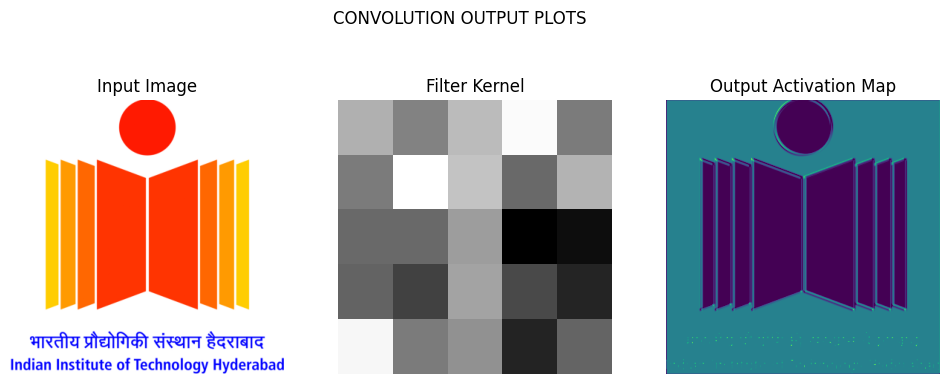

In [6]:
# Apply convolution operation
output_activation = convolution(image_iith_logo, filter_kernel, stride=1, padding=1, activation='relu')

def plot_convolution(image,filter_kernel,output_activation):
    # Display input image and output activation map
    plt.figure(figsize=(12, 7))
    plt.suptitle("CONVOLUTION OUTPUT PLOTS")

    # plt.suptitle("Convolution Output")
    plt.subplot(1, 3, 1)
    if image.shape[2]>3:
        plt.imshow(image[:,:,0])
    else:
        plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(filter_kernel, cmap='gray') 
    plt.title('Filter Kernel')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(output_activation)
    plt.title('Output Activation Map')
    plt.axis('off')
    plt.subplots_adjust(top=1.2)


plot_convolution(image_iith_logo,filter_kernel[:,:,0],output_activation)

##  Observations

1. I took image of IITH Logo of shape 369x369x3 i.e with three channels,created the corresponding kernel of shape 5x5x3 initialized with xavier initialization method.
2. Implemented the convolution function and associated functions for non linear activation functions
3. Plotted the input image,filter kernel and output activation map

# Question 2 
**Pooling function**:
It accepts as input 
* the activation map output from the convolution function,
* a pooling function (e.g., min pooling, max pooling, mean pooling, etc.),
* stride. Default stride should be equal to the width/height of the kernel).

1. The function must output the appropriately pooled activation map. 
2. Display the input activation map and the pooled output. 
3. A special case for performing Global Average/Max/Min Pooling should also be provided.

In [7]:
def Pooling_layer(image, kernel_size=(3, 3), stride=None, pooling_type='max'):
    # to set the default value of stride to kernel height 
    if stride is None:
        stride = kernel_size[0]

    h_prev, w_prev, num_channels = image.shape

    if pooling_type == 'global_avg':
        pooling_output = np.mean(image, axis=(0, 1))  # Global average pooling
    elif pooling_type == 'global_max':
        pooling_output = np.max(image, axis=(0, 1))  # Global max pooling
    elif pooling_type == 'global_min':
        pooling_output = np.min(image, axis=(0, 1))  # Global min pooling
    else:
        # compute output dimensions after the max pooling
        h = int((h_prev - kernel_size[1]) / stride) + 1
        w = int((w_prev - kernel_size[0]) / stride) + 1

        # hold the values of the pooling
        pooling_output = np.zeros((h, w, num_channels))

        for i in range(num_channels):
            curr_y = out_y = 0
            while curr_y + kernel_size[1] <= h_prev:
                curr_x = out_x = 0
                while curr_x + kernel_size[0] <= w_prev:
                    patch = image[curr_y:curr_y + kernel_size[1], curr_x:curr_x + kernel_size[0], i]
                    if pooling_type == 'max':
                        pooling_output[out_y, out_x, i] = np.max(patch)
                    elif pooling_type == 'min':
                        pooling_output[out_y, out_x, i] = np.min(patch)
                    elif pooling_type == 'avg':
                        pooling_output[out_y, out_x, i] = np.mean(patch)
                    curr_x += stride
                    out_x += 1
                curr_y += stride
                out_y += 1

        # plotting the pooling layer output
        plot_pooling(image,pooling_output)

    return pooling_output


In [8]:
def plot_pooling(input_activation_map,pooling_output):
    # Display input activation map and pooling output
    plt.figure(figsize=(12, 7))
    
    
    plt.subplot(1, 3, 1)
    plt.suptitle("POOLING OUTPUT PLOTS")

    if input_activation_map.shape[2]>3:
        plt.imshow(input_activation_map[:,:,0])
    else:
        plt.imshow(input_activation_map)
    plt.title('Input Activation Map')
    plt.axis('off')

    
    plt.subplot(1, 3, 2)
    if pooling_output.shape[2]>3:
        # plotting the 1st channel output in case of multiple channels
        plt.imshow(pooling_output[:,:,0])
    else:
        plt.imshow(pooling_output)
    
    plt.title('Pooling Output')
    plt.axis('off')
    plt.subplots_adjust(top=1.2,bottom=0.2)


## Observations

1. Has implemented the pooling function with special case for global max pooling,global average pooling and global min pooling.
2. It should be noted that plotting function for plotting pooled output generates the plot for the first channel of the pooled output.
3. The generated plot will be visible in the subsequent part where Pooling_layer function will be used to build the model.


# Question 3 

**Convolution layer function** : It accepts as input 
* a volume (image or activation maps)
*  number of filters
*  kernel dimensions
*  stride
*  padding
* non-linear activation function.

The function must 
1. initialize the kernel parameters,
2. convolve the input volume (after padding if specified) with each kernel (at the specified stride size)
3. generate an output activation volume after applying the specified non-linearity.
4. Display the input image or activation maps, the filter kernels, and the output activation maps.      
5. Verify that the output of this function does indeed have the expected size (W × H × C) as discussed in class.

In [9]:
def Convolution_layer(image, kernel_size,num_filters, stride, padding, activation_function='relu'):
    """
    Convolutional layer function.

    Parameters:
    - input_volume: Input volume (image or activation maps), numpy array of shape (height, width, channels).
    - num_filters: Number of filters in the convolutional layer, an integer.
    - kernel_size: Kernel dimensions, a tuple (kernel_height, kernel_width).
    - stride: Stride size for the convolution operation, an integer.
    - padding: Padding size, an integer.
    - activation_function: Non-linear activation function, a function that operates element-wise on numpy arrays.

    Returns:
    - output_volume: Output activation volume, numpy array of shape (output_height, output_width, num_filters).
    """
    
    # Initialize the kernel using Glorot normal initializer
    kernel_size = (kernel_size[0],kernel_size[1],image.shape[2])
    filter_kernel = glorot_normal_initializer(kernel_size)

    # Extract dimensions
    image_height, image_width, image_channels = image.shape
    kernel_height, kernel_width,kernel_channels = filter_kernel.shape

    # Ensure the number of input channels in the filter kernel matches the input image
    assert image_channels == kernel_channels, "Number of input channels must match the filter kernel"
    
    # Compute output dimensions
    output_height = (image_height - kernel_height + 2 * padding) // stride + 1
    output_width = (image_width - kernel_width + 2 * padding) // stride + 1
    
    # Initialize output activation map
    output_activation = np.zeros((output_height, output_width,num_filters))
   
    for i in range(num_filters):
        # Apply convolution operation
        output_activation[:,:,i] = convolution(image,filter_kernel, stride, padding, activation=activation_function)
    plot_convolution(image,filter_kernel[:,:,0],output_activation[:,:,0])
        
    return output_activation



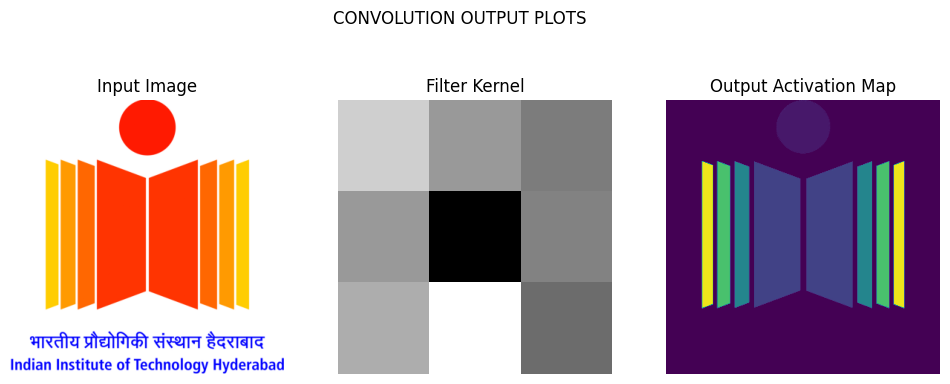

In [10]:
convolved_output = Convolution_layer(image_iith_logo,kernel_size=(3,3),num_filters=16, stride=1,padding=0,activation_function='relu')


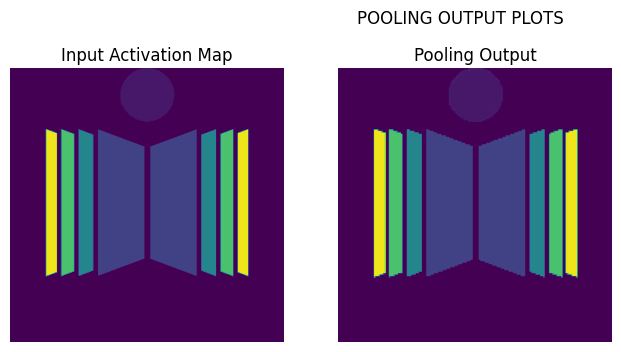

In [11]:
pooling_output = Pooling_layer(convolved_output,kernel_size=(2, 2), stride=2, pooling_type='max')


In [12]:

print("Convolution output shape",convolved_output.shape)

print("Pooling output shape ",pooling_output.shape)

Convolution output shape (367, 367, 16)
Pooling output shape  (183, 183, 16)


## Observations

1. The above function displays the input activation map/image,the filter kernels, and the output activation map
2. The Convolution output shape is 367x367x16 which is of the form WxHxC
where W = Width
    H = Height
   C = No of channels(here it is equal to number of filters used)


# Question 4 

**Multilayer Perceptron (MLP) function:**
It accepts as input 
* a vector
* number of hidden layers,
* size of each hidden layer,
* non-linear function
* size of the output layer.

This function should generate 
1. an output vector of the specified size.
2. Generate the output with and without the softmax function applied to the output layer.

In [13]:
def Mlp_layer(input_vector, hidden_layers,output_size,apply_softmax=True):
    """
    Multilayer Perceptron (MLP) function
    
    :param input_vector (ndarray): Input vector to the MLP.
    :param hidden_layers (int): Number of hidden layers.
    :param hidden_size (int or list of ints): Size of each hidden layer. If int, same size for all layers.
    :param activation_func (str): Activation function to be used ('sigmoid', 'relu', etc.).
    :param output_size (int): Size of the output layer.
    :param apply_softmax (bool): Whether to apply softmax to the output layer or not.
        
    Returns:
        ndarray: Output vector of the MLP.
    """
    hidden_size = input_vector.shape[0]
    if isinstance(hidden_size, int):
        hidden_size = [hidden_size] * hidden_layers
    
    weights = []
    biases = []
    
    # Initialize weights and biases for hidden layers
    input_size = len(input_vector)
    for size in hidden_size:
        weights.append(np.random.randn(input_size, size))
        biases.append(np.zeros(size))
        input_size = size

    # Initialize weights and biases for output layer
    weights.append(np.random.randn(input_size, output_size))
    biases.append(np.zeros(output_size))

    # Forward pass
    layer_output = input_vector
    for w, b in zip(weights, biases):
        if b.shape[0]==output_size:
            Z = np.dot(layer_output, w) + b
            if apply_softmax:
                layer_output = softmax(Z)
            else:
                layer_output = Z
        else:
            layer_output = relu(np.dot(layer_output, w) + b)
    return layer_output



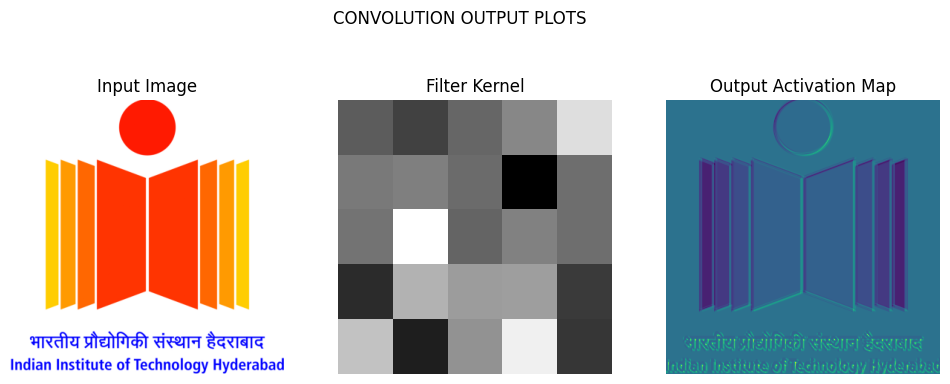

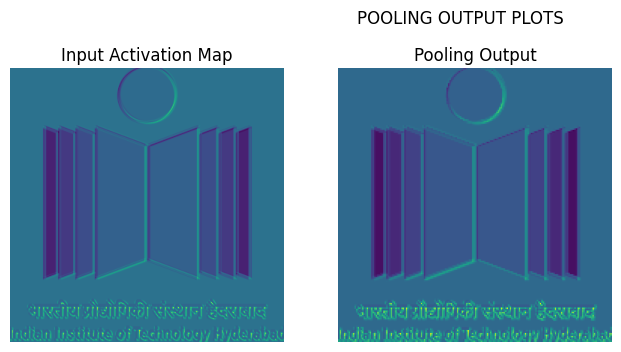

In [14]:
convolved_output_1 = Convolution_layer(image_iith_logo,kernel_size=(5,5),num_filters=16, stride=1,padding=0,activation_function='relu')
pooling_output_1 = Pooling_layer(convolved_output_1,kernel_size=(2, 2), stride=2, pooling_type='max')
pooling_output_2 = Pooling_layer(pooling_output_1,pooling_type='global_avg')
mlp_output_with_softmax = Mlp_layer(pooling_output_2,hidden_layers=1,output_size=1000)
mlp_output_without_softmax = Mlp_layer(pooling_output_2,hidden_layers=1,output_size=1000,apply_softmax=False)


In [15]:
print("MLP output with softmax shape -> ",mlp_output_with_softmax.shape)
print(mlp_output_with_softmax[:10])

MLP output with softmax shape ->  (1000,)
[2.90155077e-31 2.58611900e-21 9.66950881e-35 4.82861332e-26
 7.04934120e-24 1.07243614e-31 3.66009021e-29 2.41821879e-29
 4.57551491e-11 2.31074640e-40]


In [16]:
print("MLP output without softmax shape -> ",mlp_output_without_softmax.shape)
print(mlp_output_without_softmax[:10])

MLP output without softmax shape ->  (1000,)
[-16.9412097    1.30430392 -13.26887212  -1.35269215   8.01203139
  -0.62472776   0.36258903   1.03986182  -7.37809267   2.73165575]


## Observation

1. Implemented the MLP Layer
2. Generated the output of MLP layer with and without softmax in the final layer which is of expected output shape of (1000,)


# Question 5
**Putting-it all together:** 
Use the functions you have written to implement a CNN with the following architecture. 
* The CNN must accept an image input and output a vector of appropriate dimension. In other words, the function must effectively implement the feed-forward path in a CNN.
• Input image of size 224×224×3. Use validation images (or, random crops) from the ILSVRC dataset.       • Convolution layer with 16 kernels of size 5 × 5 spatial dimensions and ReLU activation.       • Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.      • Convolution layer with 32 kernels of spatial size 3 × 3 and sigmoid activation.       • Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.       • A Global Average Pooling (GAP) layer.      • An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s output and maps it to 1000 output nodes. Use ReLU activation for the MLP (softmax in the o/p layer).      
Verify that your composition of function accepts and image input and outputs a vector.

In [17]:
def build_model(image,padding=0):
    convolved_output_1 = Convolution_layer(image,kernel_size=(5,5),num_filters=16, stride=1,padding=0,activation_function='relu')
    pooling_output_1 = Pooling_layer(convolved_output_1,kernel_size=(2, 2), stride=2, pooling_type='max')
    convolved_output_2 = Convolution_layer(pooling_output_1,kernel_size=(3,3),num_filters=32, \
                                           stride=1,padding=0,activation_function='sigmoid')
    pooling_output_2 = Pooling_layer(convolved_output_2, kernel_size=(2, 2), stride=2, pooling_type='max')
    pooling_output_3 = Pooling_layer(pooling_output_2,pooling_type='global_avg')
    mlp_output_1 = Mlp_layer(pooling_output_3,hidden_layers=1,output_size=1000)
    return mlp_output_1


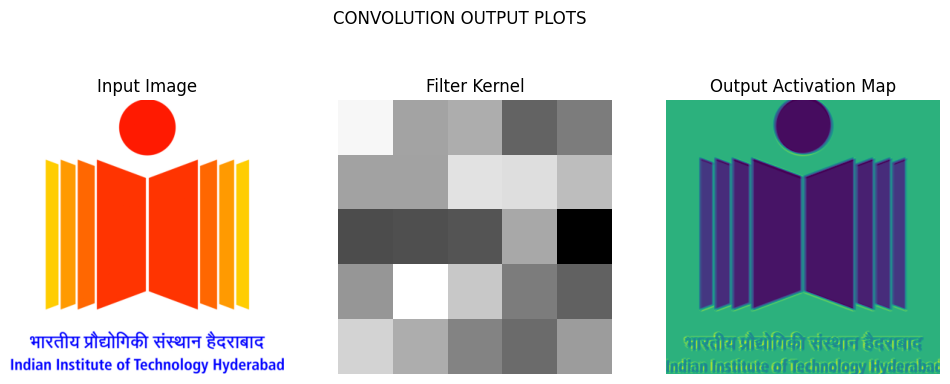

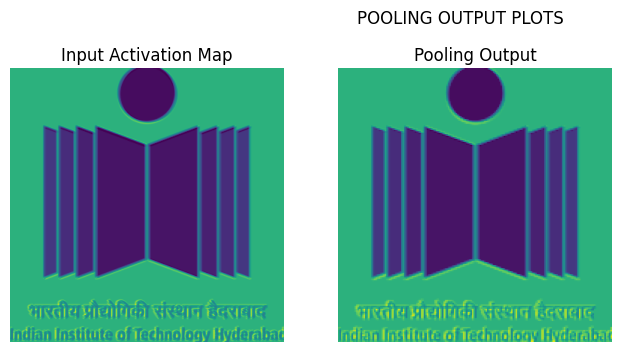

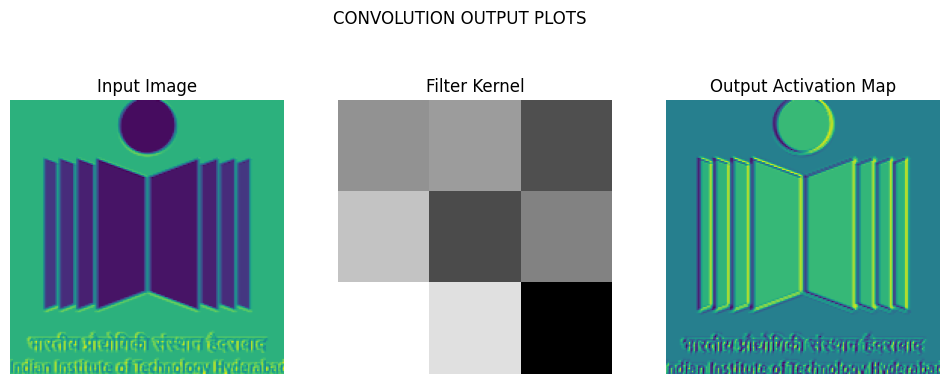

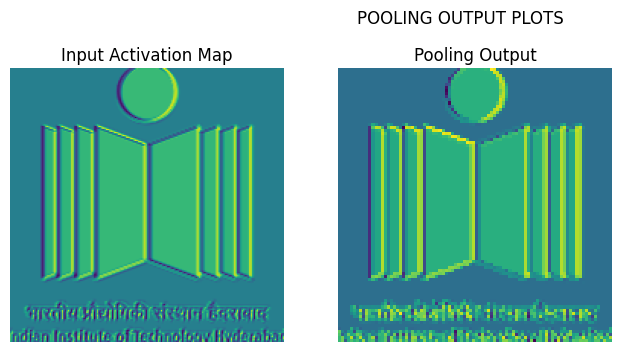

In [18]:
model_output_iith_logo = build_model(image_iith_logo)

In [19]:
model_output_iith_logo = model_output_iith_logo.reshape(-1,1)
assert model_output_iith_logo.shape == (1000, 1), "Incorrect shape of model output"

(224, 224, 3)


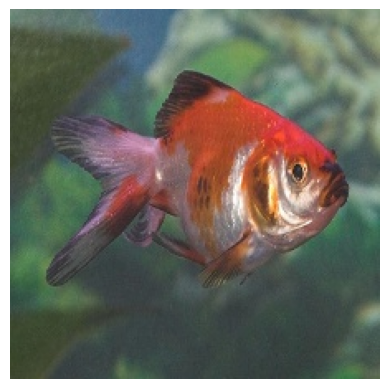

In [20]:
image_ilsvrc = plot_image('ilsvrc_image2.jpg')

/var/folders/fs/1_sgn68n2914x1m2zltpc2m80000gn/T/ipykernel_6435/1936514088.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


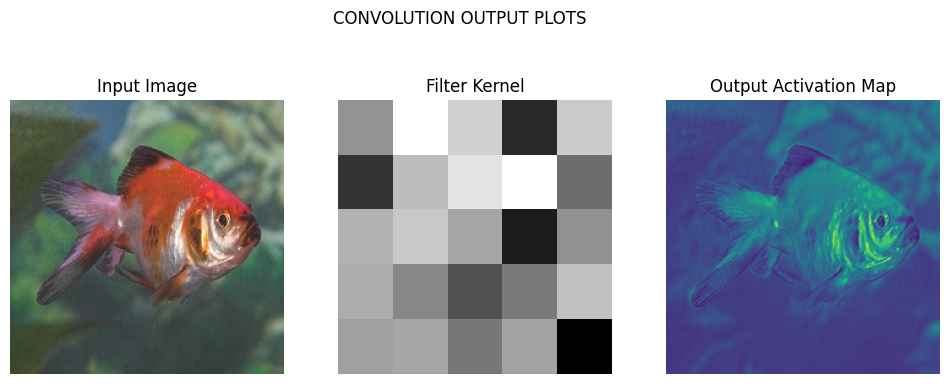

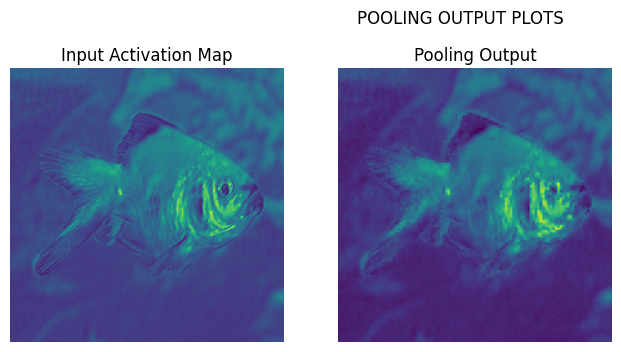

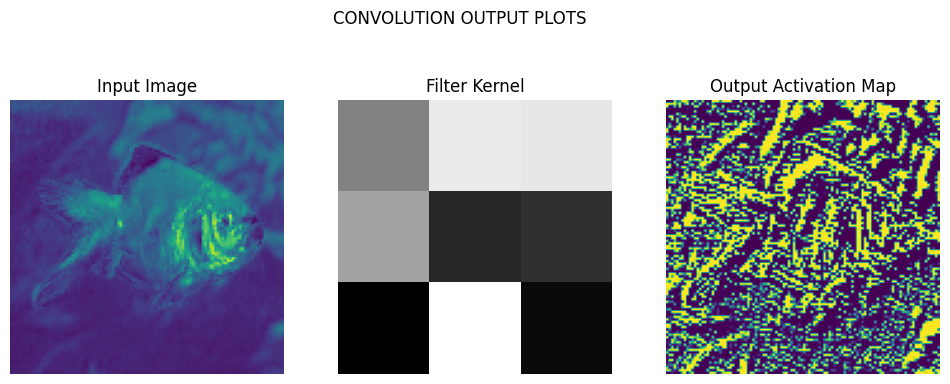

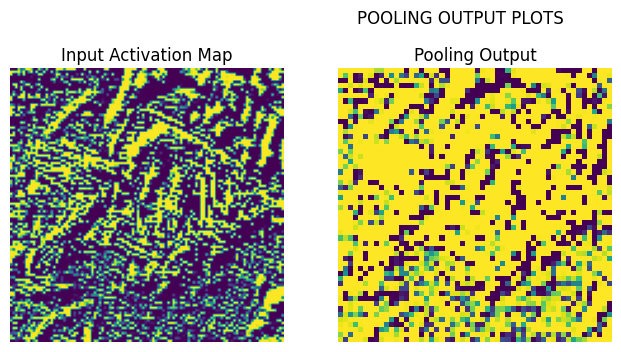

In [21]:
model_output_ilsvrc = build_model(image_ilsvrc)

In [22]:
model_output_ilsvrc = model_output_ilsvrc.reshape(-1,1)
assert model_output_ilsvrc.shape == (1000, 1), "Incorrect shape of model output"

##  Observations

1. Implemented the final function which uses the all previous functions of convolution,pooling and mlp
2. The function accepts an image and produces an output of shape (1000,1) which has been verified as well

# Question 6

**The adding problem:** In this task, each data sample consists of a sequence of variable length, but a constant depth (size of feature vector at each time instance) of 2.    

All values of the first dimension (randomly) lie in [0, 1], and the second dimension is all zeros except for two elements that are marked by 1.      

The objective of the task is to `sum the random values whose second dimensions are marked by 1`.          
Train the different RNNs (Elmon network, LSTM, and GRU) discussed in the class and compare their performance against a baseline that always predicts a sum of 1 plotting the learning curves and final performance.    

### Dataset Generation

In [23]:
# Generate dataset
def generate_sample(sequence_length):
    # Generate random float values for the first dimension
    first_dim_values = np.random.rand(sequence_length)
    
    # Mark random positions with 1 in the second dimension
    # marked_positions = np.random.choice(sequence_length, np.random.randint(1, sequence_length), replace=False)
    marked_positions = np.random.choice(sequence_length,2, replace=False)
    second_dim_values = np.zeros(sequence_length)
    second_dim_values[marked_positions] = 1
    
    return np.column_stack((first_dim_values, second_dim_values))

def generate_dataset(num_samples, max_sequence_length):
    x_val = []
    y_val = []
    for _ in range(num_samples):
        sequence_length = np.random.randint(2, max_sequence_length + 1)
        x = generate_sample(sequence_length)
        x_val.append(x)  # Store only the first dimension values in X
        # Compute Y by summing up first dimension values where second dimension is 1
        y = np.sum(x[:, 0] * x[:, 1])
        y_val.append(y)
    return x_val, y_val  # Return X_dataset as a list of arrays


In [24]:
# Generate dataset
num_samples = 5000
max_sequence_length = 20
X_train, y_train = generate_dataset(num_samples, max_sequence_length)

In [25]:
print(len(X_train))

5000


In [26]:
print(len(y_train))

5000


In [27]:
assert len(X_train) == num_samples, "Shape of X_train is not as expected"
assert len(y_train) == num_samples, "Shape of y_train is not as expected"

In [28]:
for i in range(5):
    print(X_train[i].shape)
    print(X_train[i])
    print(y_train[i])
    print()

(15, 2)
[[0.86750486 0.        ]
 [0.42907613 0.        ]
 [0.81866179 0.        ]
 [0.4516758  1.        ]
 [0.5670803  0.        ]
 [0.63181026 0.        ]
 [0.51662595 1.        ]
 [0.53359333 0.        ]
 [0.50671805 0.        ]
 [0.41282075 0.        ]
 [0.89611767 0.        ]
 [0.23895541 0.        ]
 [0.97265209 0.        ]
 [0.77629025 0.        ]
 [0.55363241 0.        ]]
0.9683017449936133

(2, 2)
[[0.2699027  1.        ]
 [0.06256221 1.        ]]
0.33246491312492765

(7, 2)
[[0.02291653 0.        ]
 [0.2958733  0.        ]
 [0.42887326 0.        ]
 [0.60007391 1.        ]
 [0.56995122 0.        ]
 [0.3399728  0.        ]
 [0.67810179 1.        ]]
1.2781756999050096

(15, 2)
[[0.50415138 0.        ]
 [0.4063428  0.        ]
 [0.05723636 1.        ]
 [0.76213428 1.        ]
 [0.71694313 0.        ]
 [0.71594245 0.        ]
 [0.99423135 0.        ]
 [0.83833417 0.        ]
 [0.26687566 0.        ]
 [0.14562657 0.        ]
 [0.44968087 0.        ]
 [0.83285662 0.        ]
 [0.15

## ELMAN RNN


In [29]:
# Define ElmanRNN class
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size

        # Parameters
        self.Wih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.Tensor(hidden_size))
        
        self.Who = nn.Parameter(torch.Tensor(hidden_size, output_size))
        self.bo = nn.Parameter(torch.Tensor(output_size))

        # self.fc = nn.Linear(hidden_size, output_size)

        # Initialize parameters
        nn.init.normal_(self.Wih, mean=0, std=0.01)
        nn.init.normal_(self.Whh, mean=0, std=0.01)
        nn.init.normal_(self.Who, mean=0, std=0.01)
        nn.init.constant_(self.bh, 0)
        nn.init.constant_(self.bo, 0)

    def forward(self, inputs):
        batch_size = inputs.size(0)
        seq_length = inputs.size(1)
        h = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)  # Initialize hidden state
        output = torch.mm(h, self.Who) + self.bo
        for t in range(seq_length):
            x = inputs[:, t, :]  # Input at time step t
            h = torch.tanh(torch.mm(x, self.Wih) + torch.mm(h, self.Whh) + self.bh)
            output = torch.mm(h, self.Who) + self.bo
            
        return output


In [30]:
# Hyperparameters
input_size = 2  # Adjusted input size to match the size of X
hidden_size = 5
output_size = 1
batch_size = 32
num_epochs = 100
learning_rate = 0.001

criterion = nn.MSELoss()


In [31]:
def train_model_batchwise(model,criterion,X_train,num_epochs=100):
    """
    Function using padding to make sequence of same size and
    creating batches for faster training and computation.
    """
    start_time = time()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    # Pad sequences
    X_train_padded = [torch.tensor(seq).float() for seq in X_train]
    X_train_padded = pad_sequence(X_train_padded, batch_first=True)
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0;num_samples_per_epoch = 0
        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()
            batch_X = X_train_padded[i:i+batch_size]
            batch_y = torch.tensor(y_train[i:i+batch_size]).float()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_samples_per_epoch+=1
            
        epoch_loss /= (num_samples_per_epoch*1.0)
        train_losses.append(epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    end_time = time()
    print("Total Training Time ",end_time-start_time)
    return train_losses


In [32]:
def train_model_sgd(model,criterion,X_train,batch_size=1,num_epochs=100):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = [];
    start_time = time()
    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0;num_samples_per_epoch = 0
        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()

            batch_X = X_train[i:i+batch_size]
            batch_y = torch.tensor(y_train[i:i+batch_size]).float()

            # Pad sequence
            batch_X_padded = [torch.tensor(seq).float() for seq in batch_X]
            batch_X_padded = pad_sequence(batch_X_padded, batch_first=True)
            
            outputs = model(batch_X_padded)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_samples_per_epoch+=1
        epoch_loss/=(num_samples_per_epoch*1.0)
        train_losses.append(epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    end_time = time()
    print("Total Training Time ",end_time-start_time)
    return train_losses


In [33]:
# Function to compute Mean Absolute Percentage Error (MAPE)
def compute_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


def create_validation_dataset(num_datapoints=1000):
    X_val, y_val = generate_dataset(num_datapoints, max_sequence_length)
    X_val_padded = [torch.tensor(seq).float() for seq in X_val]
    X_val_padded = pad_sequence(X_val_padded, batch_first=True)
    return X_val_padded,y_val

def compute_validation_metrics(model,validation_data):
    X_val_padded,y_val = validation_data
    # Generate validation dataset

    # Evaluate the model
    model_gru.eval()
    with torch.no_grad():
        print(X_val_padded.shape)
        val_outputs = model_gru(X_val_padded)
    print(val_outputs.size())
    val_loss = criterion(val_outputs, torch.tensor(y_val).float().view(-1, 1)).item()
    print(val_loss)
    val_mse = nn.MSELoss()(val_outputs, torch.tensor(y_val).float().view(-1, 1))
    val_mape = compute_mape(np.array(y_val), val_outputs.numpy().flatten())

    
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation MSE: {val_mse:.4f}')
    print(f'Validation MAPE: {val_mape:.4f}%')
    print()


In [34]:
# Instantiate ElmanRNN model
model_elman_batchwise = ElmanRNN(input_size, hidden_size, output_size)
train_loss_elman_batchwise = train_model_batchwise(model_elman_batchwise,criterion,X_train,num_epochs=300)

Epoch [1/300], Loss: 0.7169
Epoch [2/300], Loss: 0.1688
Epoch [3/300], Loss: 0.1686
Epoch [4/300], Loss: 0.1686
Epoch [5/300], Loss: 0.1686
Epoch [6/300], Loss: 0.1686
Epoch [7/300], Loss: 0.1686
Epoch [8/300], Loss: 0.1686
Epoch [9/300], Loss: 0.1685
Epoch [10/300], Loss: 0.1685
Epoch [11/300], Loss: 0.1685
Epoch [12/300], Loss: 0.1685
Epoch [13/300], Loss: 0.1685
Epoch [14/300], Loss: 0.1685
Epoch [15/300], Loss: 0.1685
Epoch [16/300], Loss: 0.1685
Epoch [17/300], Loss: 0.1685
Epoch [18/300], Loss: 0.1685
Epoch [19/300], Loss: 0.1685
Epoch [20/300], Loss: 0.1685
Epoch [21/300], Loss: 0.1685
Epoch [22/300], Loss: 0.1684
Epoch [23/300], Loss: 0.1684
Epoch [24/300], Loss: 0.1684
Epoch [25/300], Loss: 0.1684
Epoch [26/300], Loss: 0.1684
Epoch [27/300], Loss: 0.1684
Epoch [28/300], Loss: 0.1684
Epoch [29/300], Loss: 0.1684
Epoch [30/300], Loss: 0.1684
Epoch [31/300], Loss: 0.1684
Epoch [32/300], Loss: 0.1684
Epoch [33/300], Loss: 0.1684
Epoch [34/300], Loss: 0.1683
Epoch [35/300], Loss: 0

In [35]:
# Instantiate ElmanRNN model
model_elman_sgd = ElmanRNN(input_size, hidden_size, output_size)
train_loss_elman_sgd = train_model_sgd(model_elman_sgd,criterion,X_train,num_epochs=100)

Epoch [1/100], Loss: 0.1757
Epoch [2/100], Loss: 0.1509
Epoch [3/100], Loss: 0.1500
Epoch [4/100], Loss: 0.1488
Epoch [5/100], Loss: 0.1470
Epoch [6/100], Loss: 0.1438
Epoch [7/100], Loss: 0.1378
Epoch [8/100], Loss: 0.1264
Epoch [9/100], Loss: 0.0935
Epoch [10/100], Loss: 0.0374
Epoch [11/100], Loss: 0.0180
Epoch [12/100], Loss: 0.0125
Epoch [13/100], Loss: 0.0098
Epoch [14/100], Loss: 0.0080
Epoch [15/100], Loss: 0.0068
Epoch [16/100], Loss: 0.0060
Epoch [17/100], Loss: 0.0055
Epoch [18/100], Loss: 0.0051
Epoch [19/100], Loss: 0.0048
Epoch [20/100], Loss: 0.0045
Epoch [21/100], Loss: 0.0043
Epoch [22/100], Loss: 0.0042
Epoch [23/100], Loss: 0.0040
Epoch [24/100], Loss: 0.0039
Epoch [25/100], Loss: 0.0038
Epoch [26/100], Loss: 0.0038
Epoch [27/100], Loss: 0.0037
Epoch [28/100], Loss: 0.0036
Epoch [29/100], Loss: 0.0036
Epoch [30/100], Loss: 0.0036
Epoch [31/100], Loss: 0.0035
Epoch [32/100], Loss: 0.0035
Epoch [33/100], Loss: 0.0035
Epoch [34/100], Loss: 0.0035
Epoch [35/100], Loss: 0

## LSTM RNN

In [36]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for input gate
        self.W_ii = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_ii = nn.Parameter(torch.Tensor(hidden_size))

        # Parameters for forget gate
        self.W_if = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_if = nn.Parameter(torch.Tensor(hidden_size))

        # Parameters for cell gate
        self.W_ig = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_ig = nn.Parameter(torch.Tensor(hidden_size))

        # Parameters for output gate
        self.W_io = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_io = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / (self.hidden_size ** 0.5)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, h0, c0):
        batch_size = x.size(0)
        seq_length = x.size(1)
        hidden_seq = []

        h_t, c_t = h0, c0
        for t in range(seq_length):
            x_t = x[:, t, :]
            
            # Concatenate x_t and h_t
            x_h_concat = torch.cat((x_t, h_t), dim=1)

            # Input gate
            i_t = torch.sigmoid(x_h_concat @ self.W_ii + self.b_ii)

            # Forget gate
            f_t = torch.sigmoid(x_h_concat @ self.W_if + self.b_if)

            # Intermediary Cell gate
            g_t = torch.tanh(x_h_concat @ self.W_ig + self.b_ig)

            # Output gate
            o_t = torch.sigmoid(x_h_concat @ self.W_io + self.b_io)

            # Update Final cell state
            c_t = f_t * c_t + i_t * g_t

            # Update hidden state
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)
        return hidden_seq, (h_t, c_t)

class ModelLSTMBatchwise(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes, sequence_length):
        super(ModelLSTMBatchwise, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = LSTMCell(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(batch_size, self.hidden_size)
        c0 = torch.zeros(batch_size, self.hidden_size)

        out, _ = self.lstm(x, h0, c0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out

class ModelLSTMNonBatchwise(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ModelLSTMNonBatchwise, self).__init__()
        self.hidden_size = hidden_size
        # self.num_layers = num_layers

        self.lstm = LSTMCell(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()


    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(batch_size, self.hidden_size)
        c0 = torch.zeros(batch_size, self.hidden_size)

        out, (h_t,c_t) = self.lstm(x, h0, c0)
        h_t = h_t.view(-1, self.hidden_size)
        out = self.relu(h_t)
        out = self.fc1(out)
        return out


In [37]:
model_lstm_batchwise = ModelLSTMBatchwise(input_size, hidden_size, output_size,max_sequence_length)
train_loss_lstm_batchwise = train_model_batchwise(model_lstm_batchwise,criterion,X_train,num_epochs=100)

Epoch [1/100], Loss: 0.2851
Epoch [2/100], Loss: 0.1607
Epoch [3/100], Loss: 0.1549
Epoch [4/100], Loss: 0.1455
Epoch [5/100], Loss: 0.1321
Epoch [6/100], Loss: 0.1075
Epoch [7/100], Loss: 0.0489
Epoch [8/100], Loss: 0.0205
Epoch [9/100], Loss: 0.0134
Epoch [10/100], Loss: 0.0103
Epoch [11/100], Loss: 0.0085
Epoch [12/100], Loss: 0.0073
Epoch [13/100], Loss: 0.0065
Epoch [14/100], Loss: 0.0058
Epoch [15/100], Loss: 0.0052
Epoch [16/100], Loss: 0.0048
Epoch [17/100], Loss: 0.0044
Epoch [18/100], Loss: 0.0040
Epoch [19/100], Loss: 0.0037
Epoch [20/100], Loss: 0.0034
Epoch [21/100], Loss: 0.0031
Epoch [22/100], Loss: 0.0029
Epoch [23/100], Loss: 0.0027
Epoch [24/100], Loss: 0.0025
Epoch [25/100], Loss: 0.0023
Epoch [26/100], Loss: 0.0021
Epoch [27/100], Loss: 0.0019
Epoch [28/100], Loss: 0.0018
Epoch [29/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0015
Epoch [31/100], Loss: 0.0014
Epoch [32/100], Loss: 0.0014
Epoch [33/100], Loss: 0.0013
Epoch [34/100], Loss: 0.0012
Epoch [35/100], Loss: 0

In [38]:
model_lstm_sgd = ModelLSTMNonBatchwise(input_size, hidden_size, output_size)
train_loss_lstm_sgd = train_model_sgd(model_lstm_sgd,criterion,X_train,num_epochs=100)

Epoch [1/100], Loss: 0.4202
Epoch [2/100], Loss: 0.0569
Epoch [3/100], Loss: 0.0101
Epoch [4/100], Loss: 0.0052
Epoch [5/100], Loss: 0.0034
Epoch [6/100], Loss: 0.0023
Epoch [7/100], Loss: 0.0017
Epoch [8/100], Loss: 0.0014
Epoch [9/100], Loss: 0.0011
Epoch [10/100], Loss: 0.0010
Epoch [11/100], Loss: 0.0009
Epoch [12/100], Loss: 0.0008
Epoch [13/100], Loss: 0.0007
Epoch [14/100], Loss: 0.0006
Epoch [15/100], Loss: 0.0006
Epoch [16/100], Loss: 0.0005
Epoch [17/100], Loss: 0.0005
Epoch [18/100], Loss: 0.0005
Epoch [19/100], Loss: 0.0004
Epoch [20/100], Loss: 0.0004
Epoch [21/100], Loss: 0.0004
Epoch [22/100], Loss: 0.0004
Epoch [23/100], Loss: 0.0004
Epoch [24/100], Loss: 0.0004
Epoch [25/100], Loss: 0.0003
Epoch [26/100], Loss: 0.0003
Epoch [27/100], Loss: 0.0003
Epoch [28/100], Loss: 0.0003
Epoch [29/100], Loss: 0.0003
Epoch [30/100], Loss: 0.0003
Epoch [31/100], Loss: 0.0003
Epoch [32/100], Loss: 0.0003
Epoch [33/100], Loss: 0.0003
Epoch [34/100], Loss: 0.0003
Epoch [35/100], Loss: 0

## GRU RNN

In [39]:
class GRU_Cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_Cell, self).__init__()
        self.hidden_size = hidden_size
        # self.num_layers = num_layers
        
        # Parameters for the reset gate
        self.W_ir = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_ir = nn.Parameter(torch.Tensor(hidden_size))
        
        # Parameters for the update gate
        self.W_iz = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_iz = nn.Parameter(torch.Tensor(hidden_size))
        
        # Parameters for the new gate
        self.W_in = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b_in = nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / (self.hidden_size ** 0.5)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, h0):
        batch_size = x.size(0)
        seq_length = x.size(1)

        h_t = h0
        
        outputs = []
        for t in range(seq_length):
            x_t = x[:, t, :]
            
            # Concatenate x_t and h_t
            x_h_concat = torch.cat((x_t, h_t), dim=1)

            # Reset gate
            r_t = torch.sigmoid(x_h_concat @ self.W_ir + self.b_ir)
            
            # Update gate
            z_t = torch.sigmoid(x_h_concat @ self.W_iz + self.b_iz)
            

            # New gate
            n_t_temp = torch.cat(((r_t * h_t),x_t),dim=1)
            n_t = torch.tanh(n_t_temp @ self.W_in + self.b_in)
            
            # Hidden state update
            h_t = (1 - z_t) * h_t + z_t * n_t
            
            outputs.append(h_t.unsqueeze(1))
        
        outputs = torch.cat(outputs, dim=1)
        return outputs, h_t

class ModelGRUBatchwise(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, sequence_length):
        super(ModelGRUBatchwise, self).__init__()
        self.hidden_size  = hidden_size
        
        self.gru = GRU_Cell(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.hidden_size)
        
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out



class ModelGRUNonBatchwise(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ModelGRUNonBatchwise, self).__init__()
        self.hidden_size  = hidden_size
        # self.num_layers = num_layers
        self.num_classes = num_classes
        self.gru = GRU_Cell(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size,self.num_classes)
        self.relu = nn.ReLU()
    
        
    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.hidden_size)
        out, h_t = self.gru(x, h0)
        h_t = h_t.view(-1, self.hidden_size)
        out = self.relu(h_t)
        out = self.fc1(out)
        return out


In [40]:
model_gru_batchwise = ModelGRUBatchwise(input_size, hidden_size, output_size,max_sequence_length)
train_loss_gru_batchwise = train_model_batchwise(model_gru_batchwise,criterion,X_train,num_epochs=100)

Epoch [1/100], Loss: 0.1774
Epoch [2/100], Loss: 0.1607
Epoch [3/100], Loss: 0.1563
Epoch [4/100], Loss: 0.1515
Epoch [5/100], Loss: 0.1461
Epoch [6/100], Loss: 0.1398
Epoch [7/100], Loss: 0.1319
Epoch [8/100], Loss: 0.1202
Epoch [9/100], Loss: 0.0998
Epoch [10/100], Loss: 0.0648
Epoch [11/100], Loss: 0.0305
Epoch [12/100], Loss: 0.0180
Epoch [13/100], Loss: 0.0139
Epoch [14/100], Loss: 0.0112
Epoch [15/100], Loss: 0.0093
Epoch [16/100], Loss: 0.0079
Epoch [17/100], Loss: 0.0069
Epoch [18/100], Loss: 0.0061
Epoch [19/100], Loss: 0.0055
Epoch [20/100], Loss: 0.0050
Epoch [21/100], Loss: 0.0045
Epoch [22/100], Loss: 0.0042
Epoch [23/100], Loss: 0.0039
Epoch [24/100], Loss: 0.0036
Epoch [25/100], Loss: 0.0033
Epoch [26/100], Loss: 0.0031
Epoch [27/100], Loss: 0.0029
Epoch [28/100], Loss: 0.0028
Epoch [29/100], Loss: 0.0026
Epoch [30/100], Loss: 0.0025
Epoch [31/100], Loss: 0.0023
Epoch [32/100], Loss: 0.0022
Epoch [33/100], Loss: 0.0021
Epoch [34/100], Loss: 0.0020
Epoch [35/100], Loss: 0

In [41]:
model_gru_sgd = ModelGRUNonBatchwise(input_size, hidden_size,output_size)
train_loss_gru_sgd = train_model_sgd(model_gru_sgd,criterion,X_train,num_epochs=100)

Epoch [1/100], Loss: 0.2137
Epoch [2/100], Loss: 0.0853
Epoch [3/100], Loss: 0.0086
Epoch [4/100], Loss: 0.0029
Epoch [5/100], Loss: 0.0016
Epoch [6/100], Loss: 0.0012
Epoch [7/100], Loss: 0.0010
Epoch [8/100], Loss: 0.0008
Epoch [9/100], Loss: 0.0007
Epoch [10/100], Loss: 0.0007
Epoch [11/100], Loss: 0.0006
Epoch [12/100], Loss: 0.0006
Epoch [13/100], Loss: 0.0005
Epoch [14/100], Loss: 0.0005
Epoch [15/100], Loss: 0.0004
Epoch [16/100], Loss: 0.0004
Epoch [17/100], Loss: 0.0003
Epoch [18/100], Loss: 0.0003
Epoch [19/100], Loss: 0.0003
Epoch [20/100], Loss: 0.0002
Epoch [21/100], Loss: 0.0002
Epoch [22/100], Loss: 0.0002
Epoch [23/100], Loss: 0.0002
Epoch [24/100], Loss: 0.0002
Epoch [25/100], Loss: 0.0002
Epoch [26/100], Loss: 0.0001
Epoch [27/100], Loss: 0.0001
Epoch [28/100], Loss: 0.0001
Epoch [29/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0001
Epoch [31/100], Loss: 0.0001
Epoch [32/100], Loss: 0.0001
Epoch [33/100], Loss: 0.0001
Epoch [34/100], Loss: 0.0001
Epoch [35/100], Loss: 0

In [42]:
# Function to compute Mean Absolute Percentage Error (MAPE)
def compute_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


def create_validation_dataset(num_datapoints=1000):
    X_val, y_val = generate_dataset(num_samples=1000, max_sequence_length=20)
    X_val_padded = [torch.tensor(seq).float() for seq in X_val]
    X_val_padded = pad_sequence(X_val_padded, batch_first=True)
    return X_val_padded,y_val

def compute_validation_metrics(model,validation_data):
    X_val_padded,y_val = validation_data
    # Generate validation dataset

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_padded)
    val_loss = criterion(val_outputs, torch.tensor(y_val).float().view(-1, 1)).item()
    val_mse = nn.MSELoss()(val_outputs, torch.tensor(y_val).float().view(-1, 1))
    val_mape = compute_mape(np.array(y_val), val_outputs.numpy().flatten())
    
    # print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation MSE: {val_mse:.4f}')
    print(f'Validation MAPE: {val_mape:.4f}%')
    print()



In [43]:
def baseline1(y_val):
    return [1.0]*len(y_val)

def mean_squared_error_baseline(y_true):
    """
    Calculate the mean squared error (MSE) between predicted and true values.

    Args:
    - y_pred (torch.Tensor): Predicted values
    - y_true (torch.Tensor): True values

    Returns:
    - mse (float): Mean squared error
    """
    y_pred = baseline1(y_true)
    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    # Calculate MSE of baseline
    mse = torch.mean((y_pred - y_true)**2).item()
    return mse


def mape_baseline(y_true):
    """
    Calculate the mean absolute percentage error (MAPE) between predicted and true values.

    Args:
    - y_pred (torch.Tensor): Predicted values
    - y_true (torch.Tensor): True values

    Returns:
    - mape (float): Mean absolute percentage error
    """
    y_pred = baseline1(y_true)
    # Ensure both tensors are on the same device and have the same dtype
    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)

    # Calculate absolute percentage error
    absolute_percentage_error = torch.abs((y_true - y_pred) / (y_true))

    # Calculate mean absolute percentage error
    mape = torch.mean(absolute_percentage_error).item() * 100

    return mape


In [44]:
print("BATCHWISE TRAINING RESULTS ")
print("-"*100)
validation_data = create_validation_dataset(num_datapoints=1000)
print("*"*100)
print("ELMAN Metrics ")
print("*"*100)
compute_validation_metrics(model_elman_batchwise,validation_data)
print("*"*100)

print("LSTM Metrics ")
print("*"*100)
compute_validation_metrics(model_lstm_batchwise,validation_data)
print("*"*100)

print("GRU Metrics ")
print("*"*100)
compute_validation_metrics(model_gru_batchwise,validation_data)
print("*"*100)

print("Baseline Metrics ")
print("*"*100)
X,y_val = validation_data
print(f"Validation MSE {mean_squared_error_baseline(y_val)}")
print(f"Validation MAPE {mape_baseline(y_val)}%")

    

BATCHWISE TRAINING RESULTS 
----------------------------------------------------------------------------------------------------
****************************************************************************************************
ELMAN Metrics 
****************************************************************************************************
Validation MSE: 0.0006
Validation MAPE: 3.1535%

****************************************************************************************************
LSTM Metrics 
****************************************************************************************************
Validation MSE: 0.0002
Validation MAPE: 1.4903%

****************************************************************************************************
GRU Metrics 
****************************************************************************************************
Validation MSE: 0.0004
Validation MAPE: 2.0617%

****************************************************************************

In [45]:
print("TRAINING RESULTS WITHOUT PADDDING")
print("-"*100)
print("*"*100)
print("ELMAN Metrics ")
print("*"*100)
compute_validation_metrics(model_elman_sgd,validation_data)
print("*"*100)

print("LSTM Metrics ")
print("*"*100)
compute_validation_metrics(model_lstm_sgd,validation_data)
print("*"*100)

print("GRU Metrics ")
print("*"*100)
compute_validation_metrics(model_gru_sgd,validation_data)
print("*"*100)

print("Baseline Metrics ")
print("*"*100)
X,y_val = validation_data
print(f"Validation MSE {mean_squared_error_baseline(y_val)}")
print(f"Validation MAPE {mape_baseline(y_val)}%")


TRAINING RESULTS WITHOUT PADDDING
----------------------------------------------------------------------------------------------------
****************************************************************************************************
ELMAN Metrics 
****************************************************************************************************
Validation MSE: 0.0083
Validation MAPE: 13.3700%

****************************************************************************************************
LSTM Metrics 
****************************************************************************************************
Validation MSE: 0.0008
Validation MAPE: 3.0009%

****************************************************************************************************
GRU Metrics 
****************************************************************************************************
Validation MSE: 0.0000
Validation MAPE: 0.6865%

*********************************************************************

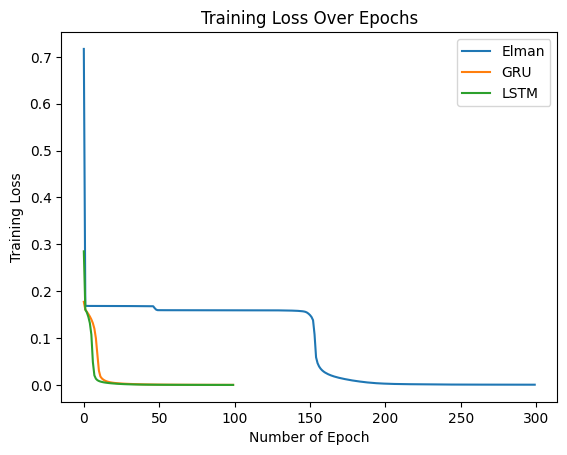

In [46]:
def plot_training_losses(train_losses_list, names_list):
    for i, train_losses in enumerate(train_losses_list):
        plt.plot(train_losses, label=names_list[i])
    
    plt.xlabel('Number of Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

train_losses_list  = []
train_losses_list.append(train_loss_elman_batchwise)
train_losses_list.append(train_loss_gru_batchwise)
train_losses_list.append(train_loss_lstm_batchwise)

names_list = ["Elman","GRU","LSTM"]

plot_training_losses(train_losses_list,names_list)


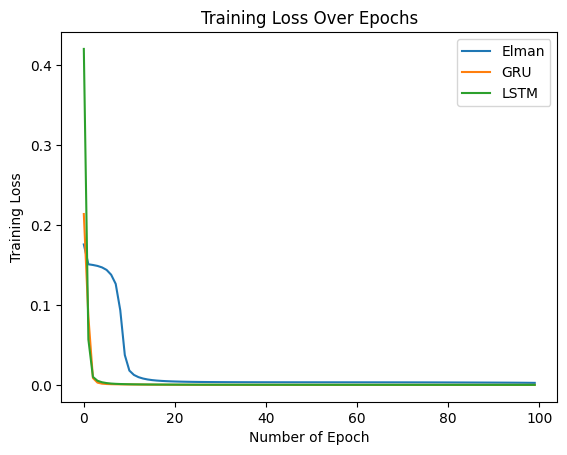

In [47]:

train_losses_list  = []
train_losses_list.append(train_loss_elman_sgd)
train_losses_list.append(train_loss_gru_sgd)
train_losses_list.append(train_loss_lstm_sgd)

names_list = ["Elman","GRU","LSTM"]

plot_training_losses(train_losses_list,names_list)


# Observations

## 1. Training Model Batchwise and with Padding 

Batch size=32


| Model Type | Mean Squared Error | Mean Absolute Percentage Error | Training Time | Number of Epochs |
|----------|----------|----------|----------|----------|
| Elman | 0.0014 | 4.9383% | 35.84 seconds | 300 |
| LSTM | 0.0002 | 1.2734% | 35.749 seconds |100 |
| GRU | 0.0003 | 1.3600% | 32.61 seconds | 100 |




## 2. Training Model without Padding and Batchsize=1

| Model Type | Mean Squared Error | Mean Absolute Percentage Error | Training Time | Number of Epochs |
|----------|----------|----------|----------|----------|
| Elman | 0.0172 | 13.5977% | 226.24 seconds | 100 |
| LSTM | 0.0023 | 5.4896% | 620.71 seconds | 100 |
| GRU | 0.0001 | 0.7886% | 520.41 seconds |100 |



**Note**:
```
1. The above produced metrics are averaged over 5 complete run  
2. The training time mentioned are as observed on running the code on Mac M1 Pro with 16GB RAM

```
Therefore the above metrics are liable to slight change.


## Other Observations
I observe that
`
1. All the RNN architectures i.e Elman,LSTM,GRU performs much better than the baseline which is evident from the lesser MSE error,MAPE error.
2. As expected the training time is lesser in batchwise training in comparison to training model by taking every datapoint at a time.
3. The batchwise training approach generally results in improved model metrics i.e less Mean Squared Error,less Mean Absolute Percentage Error for all rnn architectures

4. The advanced RNN like LSTM or GRU converges much faster than simple RNN like ELMAN rnn.
5. ELMAN RNN as expected takes comparatively less training time than more complex architectures like LSTM and GRU per epoch which can be explained due to the less number of parameters to train i.e less computation due to less complex structure.
6. The LSTM and GRU performs comparatively similar with GRU taking comparatively less time in training generally for same number of epochs.

`